***
In this notebook i will be demonstarting Latent Dirichlet Allocation(LDA) for topic modelling. I will be using the Amazon fine food reviews dataset from Kaggle(https://www.kaggle.com/snap/amazon-fine-food-reviews) for performing LDA based topic modelling
I will be using the gensim package for LDA topic modelling and pyLDAvis for visualization of LDA topic model
***

In [1]:
import pandas as pd
import numpy as np

import re
import string

import spacy #used spacy for text prepocessing

import gensim
from gensim import corpora

# libraries for visualization
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

     |████████████████████████████████| 1.7 MB 5.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=81a83f36fb5f95d5f13a56754a17466d8b606d2ac824e6cd763321605fdc0293
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
review_data= pd.read_csv("/content/Final_Lyrics_Data_Clean.csv",  encoding='utf-16', sep=',')
print(review_data.head(2))
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('Genre')))
print('Unique Users')
print(len(review_data.groupby('Unnamed: 0')))

   Unnamed: 0 Title          Artist Views Genre  Rock  Country  Pop  R&B  Rap  \
0           0   212   Azealia Banks  3.6M   Rap     0        0    0    0    1   
1           1   505  Arctic Monkeys  1.5M  Rock     1        0    0    0    0   

                                              Lyrics  
0   Hey, I can be the answer I’m ready to dance w...  
1   Im going back to 505 If its a seven-hour flig...  
418
Unique Products
5
Unique Users
418


In [4]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [5]:
#imported stopwords from nltk
import nltk
nltk.download('stopwords') # run this one time

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
review_data.dropna(axis = 0, how ='any',inplace=True) 


review_data['Lyrics'] = review_data['Lyrics'].apply(clean_text)
review_data['Num_words_text'] = review_data['Lyrics'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['Genre'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]

df_sampled = df_short_reviews.groupby('Genre').apply(lambda x: x.sample(n=1)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))



-------Dataset --------
Country    100
Rock        97
Rap         94
Pop         66
R&B         61
Name: Genre, dtype: int64
418
-------------------------
No of Short reviews
31


***
Let us pre-process the data
***

In [8]:
#This is the method for removing stopwords.
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text


df_sampled['Lyrics']=df_sampled['Lyrics'].apply(remove_stopwords)



In [9]:
!pip install spacy download en_core_web_sm

In [10]:

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [11]:

text_list=df_sampled['Lyrics'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])


moon play among stars spring like ajupiter mars words hold hand words baby kiss fill heart song sing forevermore long worship adore words please true words love fill heart song sing forevermore long worship adore words please true words words love
['star', 'ajupiter', 'word', 'hand', 'word', 'baby', 'fill', 'heart', 'song', 'sing', 'forevermore', 'long', 'adore', 'word', 'true', 'word', 'fill', 'heart', 'song', 'sing', 'forevermore', 'long', 'adore', 'word', 'true', 'word', 'word']


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

***
Create vocabulary dictionary and document term matrix
***

In [12]:
#This is one form of creating a dictionary
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [13]:
# Creating the object for LDA model using gensim library

LDA = gensim.models.ldamodel.LdaModel


lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [14]:
#Print the 10 topics

lda_model.print_topics()

[(0,
  '0.160*"room" + 0.070*"long" + 0.070*"stone" + 0.047*"death" + 0.047*"full" + 0.047*"house" + 0.025*"thing" + 0.025*"emptiness" + 0.025*"cobweb" + 0.025*"dream"'),
 (1,
  '0.014*"magic" + 0.014*"love" + 0.014*"afternoon" + 0.014*"world" + 0.014*"spell" + 0.014*"soul" + 0.014*"rose" + 0.014*"press" + 0.014*"cobweb" + 0.014*"eye"'),
 (2,
  '0.157*"wild" + 0.105*"horse" + 0.092*"word" + 0.027*"hand" + 0.027*"fill" + 0.027*"forevermore" + 0.027*"adore" + 0.027*"true" + 0.027*"sing" + 0.027*"song"'),
 (3,
  '0.014*"magic" + 0.014*"love" + 0.014*"afternoon" + 0.014*"world" + 0.014*"spell" + 0.014*"soul" + 0.014*"rose" + 0.014*"press" + 0.014*"cobweb" + 0.014*"eye"'),
 (4,
  '0.014*"magic" + 0.014*"love" + 0.014*"afternoon" + 0.014*"world" + 0.014*"spell" + 0.014*"soul" + 0.014*"rose" + 0.014*"press" + 0.014*"cobweb" + 0.014*"eye"'),
 (5,
  '0.014*"magic" + 0.014*"love" + 0.014*"afternoon" + 0.014*"world" + 0.014*"spell" + 0.014*"soul" + 0.014*"rose" + 0.014*"press" + 0.014*"cobweb" + 

In [35]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis
if np.iscomplexobj(vis):
  display(abs(vis))

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/numpy/lib/type_check.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  type_ = asarray(x).dtype.type


In [36]:

print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))

from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Perplexity:  -3.649480226614326

Coherence Score:  0.4819767306833911


***
Method to find optimal number of topics
Code from:https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore
***

In [37]:
#Compute the coherence scores by varying the number of topics

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [38]:
#Compute the coherence value by passing the dictionary, DTM, and text which is required for computing the coherence model.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

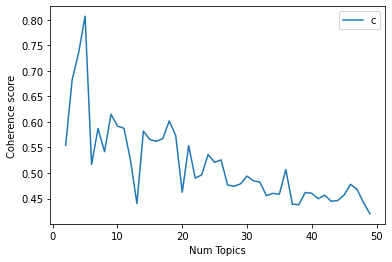

In [39]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores


In [40]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5543
Num Topics = 3  has Coherence Value of 0.6822
Num Topics = 4  has Coherence Value of 0.7353
Num Topics = 5  has Coherence Value of 0.8067
Num Topics = 6  has Coherence Value of 0.5168
Num Topics = 7  has Coherence Value of 0.5871
Num Topics = 8  has Coherence Value of 0.5417
Num Topics = 9  has Coherence Value of 0.6149
Num Topics = 10  has Coherence Value of 0.5918
Num Topics = 11  has Coherence Value of 0.5875
Num Topics = 12  has Coherence Value of 0.5257
Num Topics = 13  has Coherence Value of 0.4403
Num Topics = 14  has Coherence Value of 0.5819
Num Topics = 15  has Coherence Value of 0.5654
Num Topics = 16  has Coherence Value of 0.5619
Num Topics = 17  has Coherence Value of 0.5673
Num Topics = 18  has Coherence Value of 0.6019
Num Topics = 19  has Coherence Value of 0.5729
Num Topics = 20  has Coherence Value of 0.4622
Num Topics = 21  has Coherence Value of 0.5534
Num Topics = 22  has Coherence Value of 0.49
Num Topics = 23  has Co

In [41]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.102*"room" + 0.041*"stone" + 0.040*"long" + 0.036*"wild" + 0.036*"full" + 0.032*"death" + 0.027*"house" + 0.026*"thing" + 0.024*"horse" + 0.022*"freeway"'),
 (1,
  '0.014*"word" + 0.014*"wild" + 0.014*"long" + 0.014*"room" + 0.014*"heart" + 0.014*"horse" + 0.014*"close" + 0.014*"song" + 0.014*"adore" + 0.014*"fill"'),
 (2,
  '0.157*"wild" + 0.106*"horse" + 0.055*"room" + 0.027*"stone" + 0.026*"long" + 0.021*"thing" + 0.018*"house" + 0.018*"death" + 0.016*"full" + 0.015*"easy"'),
 (3,
  '0.178*"word" + 0.056*"forevermore" + 0.056*"adore" + 0.055*"fill" + 0.055*"song" + 0.055*"sing" + 0.055*"long" + 0.054*"heart" + 0.054*"true" + 0.030*"hand"'),
 (4,
  '0.014*"wild" + 0.014*"word" + 0.014*"long" + 0.014*"heart" + 0.014*"room" + 0.014*"horse" + 0.014*"song" + 0.014*"close" + 0.014*"world" + 0.014*"fill"'),
 (5,
  '0.057*"room" + 0.036*"long" + 0.030*"stone" + 0.028*"house" + 0.024*"death" + 0.023*"full" + 0.019*"reading" + 0.019*"freeway" + 0.019*"cobweb" + 0.019*"regret"'),
 (6

In [42]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.167291  0.017701       1        1  33.262553
0      0.094694  0.001439       2        1  28.576824
3     -0.156643  0.090666       3        1  20.772342
6     -0.144586 -0.078994       4        1  16.092426
5      0.031795 -0.007192       5        1   0.432047
1      0.003724 -0.011809       6        1   0.431904
4      0.003725 -0.011810       7        1   0.431904, topic_info=           Term      Freq     Total Category  logprob  loglift
70         room  6.000000  6.000000  Default  30.0000  30.0000
36         word  6.000000  6.000000  Default  29.0000  29.0000
24         wild  8.000000  8.000000  Default  28.0000  28.0000
10        horse  5.000000  5.000000  Default  27.0000  27.0000
31         long  4.000000  4.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
29  forevermore  0.007573  2.062390   Topic7  -4.2904  -0.1623
32         sing  0.007573  2.056056   Topic7  -4.2904  -0.1592
71        stone  0.007573  2.871730   Topic7  -4.2904  -0.4933
35         true  0.007573  2.051883   Topic7  -4.2904  -0.1572
60         full  0.007573  2.234269   Topic7  -4.2905  -0.2423

[312 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
25        3  0.485135      adore
52        2  0.791687  afternoon
26        3  0.782580   ajupiter
37        2  0.517912      angel
37        4  0.517912      angel
...     ...       ...        ...
24        2  0.121428       wild
72        2  0.726124       wine
36        3  0.770164       word
36        4  0.154033       word
51        4  0.593987      world

[88 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 7, 6, 2, 5])